In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import dateutil.parser as parser
from datetime import datetime, date, timedelta
import torch
import skorch
import scipy
import torch.nn as nn
import torch
import torch.nn.functional as F
import sys
from skorch.helper import DataFrameTransformer
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from skorch.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from skorch import NeuralNetRegressor
import pickle
import emoji
def identity_tokenizer(text):
    return text
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)

In [2]:
merged = pd.read_csv('mergedfullwithmoredates.csv')
# from sklearn.model_selection import train_test_split  
# mergedbig, mergedsmall = train_test_split(merged, test_size=0.15, random_state=0)
# mergedsmall.to_csv("mergedsmall.csv", index = False)
# mergedsmall = pd.read_csv('mergedsmall.csv')
# merged = mergedsmall
merged = merged.dropna(subset=['Change1','Change2','Change3','Change4','Change5'])
merged = merged.reset_index(drop=True)
# Obtaining the tweet contents into a list
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
merged

,text,referenced_tweets,id,lang,Date,time,usedate,usedate1,usedate2,usedate3,...,Volume,Open,High,Low,Change,Change1,Change2,Change3,Change4,Change5
0,#computer #technology #pc #tech #gaming #lapto...,1.389731e+18,1389731436152987650,und,2021-05-04,23:59:28,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
1,Super Game Talk Video Alpha! https://t.co/BgG3...,1.389727e+18,1389731281525686273,en,2021-05-04,23:58:52,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
2,Nailed the interview #apple https://t.co/QIXRf...,1.389730e+18,1389731277427908615,en,2021-05-04,23:58:51,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
3,Apple、macOS Big Sur 11.4ベータ2をリリース #Apple #ベータ ...,1.389731e+18,1389731204866269184,ja,2021-05-04,23:58:33,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
4,iPhone13 Pro MaxのCADデータを基にしたモックアップ〜ノッチが小型化 #Ap...,1.389657e+18,1389730808034861056,ja,2021-05-04,23:56:59,2021-05-04,2021-05-05,2021-05-06,2021-05-07,...,137564700.0,131.1900,131.4899,126.7000,-3.340,-1.100,1.8500,-0.64,-2.5600,2.4100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342219,"Download JOBIN THE PENGUIN! Awesome, retro-ins...",NaN,1259996823118319621,en,2020-05-12,00:00:26,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725
3342220,"2019 13"" 1.6GHz/128GB #Apple #MacBook Airs, re...",NaN,1259996818450132993,en,2020-05-12,00:00:25,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725
3342221,How to use Apple Maps mobility trends data htt...,NaN,1259996729451085827,en,2020-05-12,00:00:04,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725
3342222,AirPods Studio Could Come With Head And Neck D...,NaN,1259996725638504448,en,2020-05-12,00:00:03,2020-05-12,2020-05-13,2020-05-14,2020-05-15,...,162301040.0,79.4575,79.9220,77.7275,-1.605,-1.125,1.2575,1.84,0.4475,-0.4725


In [3]:
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Replace all emojis with text
    processed_tweet = emoji.demojize(processed_tweet)
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    
#     processed_tweet = re.sub(r'http\S+', '', processed_tweet)
    
    
#     processed_tweet = re.sub(r'co\S+', '', processed_tweet) 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
#     processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    

    
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweet = lemming(processed_tweet)
    
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)

In [4]:
y = merged[['Change','Change1','Change2','Change3','Change4','Change5','usedate','usedate1','usedate2','usedate3','usedate4','usedate5']]
# X = df3
# X = df2
# X = df2array
X = processed_tweets
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
with open("x_train_ah.txt", "rb") as fp:   # Unpickling
    x_train = pickle.load(fp)
y_train = pd.read_csv("y_train_ah.csv")
with open("x_test_ah.txt", "rb") as fp:   # Unpickling
    x_test = pickle.load(fp)
y_test = pd.read_csv("y_test_ah.csv")

In [4]:
print(len(x_train)+len(x_test))

3342224


In [6]:
y_train2 = y_train['Change2']
y_test2 = y_test['Change2']
y_train2 = y_train2.values.reshape(-1,1)
y_test2 = y_test2.values.reshape(-1,1)
y_train2 = y_train2.astype(np.float32)
y_test2 = y_test2.astype(np.float32)
in_dimension = 7665
hid_dimension = 160
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 7665
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=160,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 160)
        self.output = nn.Linear(160, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train2)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test2, y_pred, squared = False)
print("RMSE:", rmse)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        3.8897        3.8059  764.1397
      2        3.7796        3.7550  774.9678
      3        3.7402        3.7247  787.2593
      4        3.7128        3.7056  795.8884
      5        3.6911        3.6913  802.0211
      6        3.6724        3.6806  805.7384
      7        3.6540        3.6746  809.1049
      8        3.6359        3.6627  846.5984
      9        3.6171        3.6520  884.1157
     10        3.5981        3.6360  827.9429
     11        3.5787        3.6246  822.3034
     12        3.5604        3.6193  822.9707
     13        3.5429        3.6048  862.5919
     14        3.5258        3.6014  908.4054
     15        3.5097        3.5971  939.3141
     16        3.4945        3.5813  877.7656
     17        3.4801        3.5766  859.9251
     18        3.4671        3.5727  830.5020
     19        3.4543        3.5747  849.1988
     20        3.4420        3.564

In [13]:
modelpreds = y_pred
y = y_test2
z = y_test['usedate2']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [1518.086]
Accuracy: 0.6761133603238867
Sum Invested: [787.41504]
Profitability: [1.9279363]


([<matplotlib.axis.XTick at 0x1ec93716880>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

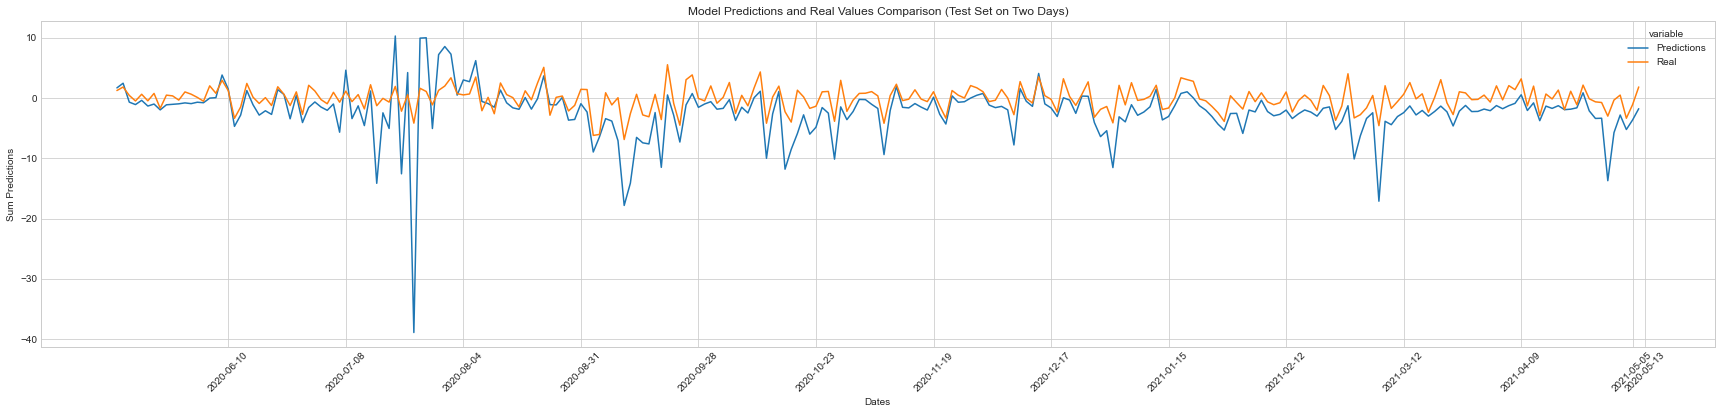

In [14]:
predsuml = [item for sublist in predsumlist for item in sublist]
realal = [item for sublist in realalist for item in sublist]

diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Model Predictions and Real Values Comparison (Test Set on Two Days)')
plt.xticks(['2020-05-13','2020-06-10', '2020-07-08', '2020-08-04', '2020-08-31',
 '2020-09-28', '2020-10-23', '2020-11-19', '2020-12-17', '2021-01-15',
 '2021-02-12', '2021-03-12', '2021-04-09','2021-05-05'],rotation=45)

In [15]:
merged = pd.read_csv('mergedfullholdout.csv')
# ,'Change2','Change3','Change4','Change5'
merged = merged.dropna(subset=['Change1'])
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
# https://python.gotrained.com/scraping-tweets-sentiment-analysis/
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Replace all emojis with text
    processed_tweet = emoji.demojize(processed_tweet)
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    # Remove single characters from the start
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    processed_tweet = lemming(processed_tweet)
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)
x_holdout = processed_tweets
y_holdout = merged['Change1']
y_holdout_dates = merged['usedate1']
y_holdout = y_holdout.values.reshape(-1,1)
y_holdout = y_holdout.astype(np.float32)

In [9]:
with open("x_holdout.txt", "rb") as fp:   # Unpickling
    x_holdout = pickle.load(fp)
with open("y_holdout.txt", "rb") as fp:   # Unpickling
    y_holdout = pickle.load(fp)
with open("y_holdout_dates.txt", "rb") as fp:   # Unpickling
    y_holdout_dates = pickle.load(fp)

y_holdout = y_holdout['Change2']
y_holdout_dates = y_holdout_dates['usedate2']
y_holdout = y_holdout.values.reshape(-1,1)
y_holdout = y_holdout.astype(np.float32)
y_pred_holdout= pipe.predict(x_holdout)
rmse = mean_squared_error(y_holdout, y_pred_holdout, squared = False)
print("RMSE:", rmse)

RMSE: 1.431924


In [10]:
modelpreds = y_pred_holdout
y = y_holdout
z = y_holdout_dates
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:

    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [-39.226444]
Accuracy: 0.4444444444444444
Sum Invested: [93.60058]
Profitability: [-0.41908336]


([<matplotlib.axis.XTick at 0x1ec91bb8640>,
 [Text(0, 0, ''), Text(0, 0, '')])

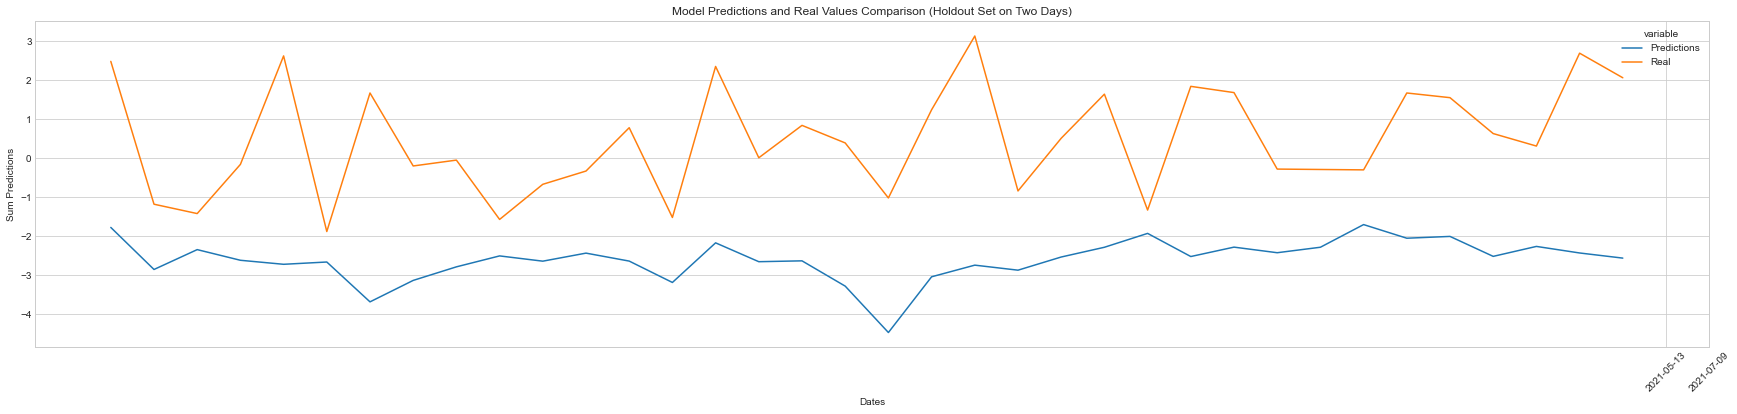

In [12]:
predsuml = [item for sublist in predsumlist for item in sublist]
realal = [item for sublist in realalist for item in sublist]

diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Model Predictions and Real Values Comparison (Holdout Set on Two Days)')
plt.xticks(['2021-05-12','2021-07-09'],rotation=45)